<a id="TOP"></a>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/60/NISAR_artist_concept.jpg" width=150/><img src="https://upload.wikimedia.org/wikipedia/commons/9/9b/NISAR_Mission_Logo.png" width=200/> 

***

# NASA ISRO Synthetic Aperture Radar Mission
## Query and Download from ASF DAAC
## Preprocess Sentinel-1 products 

Authors: Alex Christensen


## 1 &emsp; Import Python Modules

In [1]:
import os
from pathlib import Path
import sys

notebook_dir = Path(os.getcwd())
main_dir = notebook_dir.resolve().parents[0]

print(notebook_dir)
print(main_dir)
sys.path.append('/home/jovyan/.snap/snap-python')

# print(sys.path)

/Users/alchrist/Documents/GitHub/NISAR_Prep_Workflows
/Users/alchrist/Documents/GitHub


In [2]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from osgeo import gdal, osr, ogr
import subprocess

import time
import scipy
import pandas as pd
from pandas import DataFrame
from IPython.display import Image
import sklearn  # imported from scikit-learn
from sklearn import metrics
from matplotlib.pyplot import figure
from matplotlib.colors import ListedColormap
%matplotlib inline
import rasterio


from ipywidgets import interactive
from rasterio.plot import show_hist
import rasterio.mask

import asf_search as asf
import geopandas as gpd
from shapely.geometry import shape, Polygon

# from ipyleaflet import (
#     Map,  basemaps,
#     Rectangle,
#     GeoJSON,
#     DrawControl,GeoData
# )
# import ipyleaflet
import h5py
import zipfile

import snappy
from snappy import ProductIO
from snappy import HashMap
import os, gc
from snappy import GPF

ModuleNotFoundError: No module named 'snappy'

In [3]:
input_dir = notebook_dir / 'inputs'
output_dir = notebook_dir / 'outputs'
ancillary_dir = main_dir / 'ancillary_data'


## 2:  Set the Query Parameters

## 2.1: Define the AOI
Provide either a geojson defining the AOI or draw one on the map

In [4]:
aoi = 'LA_ag'
aoi_inputs = input_dir/aoi
aoi_outputs = output_dir/aoi
Path(aoi_inputs).mkdir(parents=True, exist_ok=True)
Path(aoi_outputs).mkdir(parents=True, exist_ok=True)


In [5]:
# m = Map(basemap=basemaps.Esri.WorldImagery, center=(0,0), zoom=2)
# # poly_color = '#00F'
# draw_control = DrawControl()

# draw_control.rectangle = {"shapeOptions": {"fillColor": "#fca45d", "color": "#fca45d", "fillOpacity": 1.0 }}

# def clear_m():
#     global rects,polys
#     rects = set()
#     polys = set()

# clear_m()
# def handle_draw(self, action, geo_json):
#     global rects,polys
#     polygon=[]
#     for coords in geo_json['geometry']['coordinates'][0][:-1][:]:
#         polygon.append(tuple(coords))
#     polygon = tuple(polygon)
#     if geo_json['properties']['style']['color'] == '#00F':  # poly
#         if action == 'created':
#             polys.add(polygon)
#         elif action == 'edited':
#             #polys.update(polygon)
#             polys.clear()
#             polys.add(polygon)
#         elif action == 'deleted':
#             polys.discard(polygon)

# draw_control.on_draw(handle_draw)
# m.add_control(draw_control)
  
# m

In [6]:
if os.path.isfile('%s.geojson' %(aoi_inputs/aoi))==False:
    polygon: Polygon = shape(draw_control.last_draw.get('geometry'))
    polygon.geom_type
    print(polygon)
    poly_df = gpd.GeoDataFrame(geometry=[polygon],crs='epsg:4326')
    poly_df.to_file('%s.geojson' %(aoi_inputs/aoi),driver='GeoJSON')
else:
    gdf = gpd.read_file('%s.geojson' %(aoi_inputs/aoi))
    polygon = gdf.geometry[0]

wkt = str(polygon)


## 2.2: Define the search query for NISAR data
Options (more options and details are available here: https://docs.asf.alaska.edu/api/keywords/)
- platform
- instrument
- frame
- processinglevel
- flightDirection
- start
- end
- maxResults

In [7]:
opts = {
    'platform':asf.PLATFORM.SENTINEL1,
    'processingLevel': asf.PRODUCT_TYPE.GRD_HD,
    'flightDirection':asf.FLIGHT_DIRECTION.ASCENDING,
    'start':'Feb 12, 2017',
    'end':'December 11, 2017',
    'maxResults':2
    }

## 2.3: Submit search and decide whether or not to download


In [8]:
results = asf.geo_search(intersectsWith=wkt, **opts)
print(f'{len(results)} results found')


2 results found


## 2.4: Download files.
You must enter your ASF/EarthData login credentials

In [1]:
## Change to True if you want to download all of the results. Otherwise, adjust search query before continuing
download = True

if download:
#     session = asf.ASFSession().auth_with_creds('**', '**')
    results.download(path=aoi_inputs)#, session=session)
else:
    print('Not downloading yet')

## 3: Preprocess GCOV products

## 3.1: Select area to crop

POLYGON ((-91.5056560000000019 29.6950220000000016, -91.5056560000000019 29.7880280000000006, -91.3508530000000007 29.7880280000000006, -91.3508530000000007 29.6950220000000016, -91.5056560000000019 29.6950220000000016))


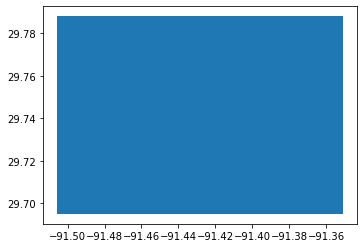

In [10]:
crop_to = gpd.read_file('%s.geojson' %(aoi_inputs/aoi))

crop_to = crop_to.to_crs("epsg:4326")

crop_to.plot()
crop_to = crop_to.explode()
shapes = crop_to.geometry[0][0].to_wkt()

print(shapes)

## 3.2: Find, unzip, and correct CRS for VV and VH files files

In [11]:


## UTM projection parameters
proj = '''PROJCS["UTM Zone 4 / World Geodetic System 1984",GEOGCS["World Geodetic System 1984",DATUM["World Geodetic System 1984",SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]],UNIT["degree", 0.017453292519943295],AXIS["Geodetic longitude", EAST],AXIS["Geodetic latitude", NORTH]],PROJECTION["Transverse_Mercator"],PARAMETER["central_meridian", -159.0],PARAMETER["latitude_of_origin", 0.0],PARAMETER["scale_factor", 0.9996],PARAMETER["false_easting", 500000.0],PARAMETER["false_northing", 0.0],UNIT["m", 1.0],AXIS["Easting", EAST],AXIS["Northing", NORTH]]'''

for zip_file in glob.glob('%s/*S1*.zip' %(aoi_inputs)):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(zip_file[:-4])
    # os.system('rm -r %s' %(zip_file))

In [20]:
for zip_file in glob.glob('%s/*S1*/' %(aoi_inputs)):
    filename = zip_file.split('/')[-2]
    print(filename)

    gc.enable()
    gc.collect()
    sentinel_1 = ProductIO.readProduct(str(aoi_inputs) + "/" + filename + "/" + filename + ".SAFE/manifest.safe")
    # print(path + "/" + zip_file[:-4] + "/" + filename[:-4] + ".SAFE/manifest.safe")
    modestamp = filename.split("_")[1]
    productstamp = filename.split("_")[2]
    polstamp = filename.split("_")[3]

    print(modestamp, productstamp,polstamp)
    
    polarization = polstamp[2:4]
    if polarization == 'DV':
        pols = 'VH,VV'
    elif polarization == 'DH':
        pols = 'HH,HV'
    elif polarization == 'SH' or polarization == 'HH':
        pols = 'HH'
    elif polarization == 'SV':
        pols = 'VV'
    else:
        print("Polarization error!")
            
    print('\tApply orbit file...')
    parameters = HashMap()
    parameters.put('Apply-Orbit-File', True)
    output = GPF.createProduct('Apply-Orbit-File', parameters, sentinel_1)
    
    # print('\tThermal noise removal...')
    # parameters = HashMap()
    # parameters.put('removeThermalNoise', True)
    # output = GPF.createProduct('ThermalNoiseRemoval', parameters, output)
    
    print('\tCalibration...')
    parameters = HashMap()
    parameters.put('outputSigmaBand', True)
    if polarization == 'DH':
        parameters.put('sourceBands', 'Intensity_HH,Intensity_HV')
    elif polarization == 'DV':
        parameters.put('sourceBands', 'Intensity_VH,Intensity_VV')
    elif polarization == 'SH' or polarization == 'HH':
        parameters.put('sourceBands', 'Intensity_HH')
    elif polarization == 'SV':
        parameters.put('sourceBands', 'Intensity_VV')
    else:
        print("different polarization!")
    parameters.put('selectedPolarisations', pols)
    parameters.put('outputImageScaleInDb', False)
    output = GPF.createProduct("Calibration", parameters, output)
    
    print('\tSpeckle filtering...')
    parameters = HashMap()
    parameters.put('filter', 'Lee')
    parameters.put('filterSizeX', 5)
    parameters.put('filterSizeY', 5)
    output = GPF.createProduct('Speckle-Filter', parameters, output)
    
    print('\tTerrain correction...')
    parameters = HashMap()
    downsample = 0
    parameters.put('demName', 'SRTM 3Sec')
    parameters.put('imgResamplingMethod', 'BILINEAR_INTERPOLATION')
    # parameters.put('mapProjection', proj)       # comment this line if no need to convert to UTM/WGS84, default is WGS84
    # parameters.put('saveProjectedLocalIncidenceAngle', True)
    parameters.put('saveSelectedSourceBand', True)
    while downsample == 1:                      # downsample: 1 -- need downsample to 40m, 0 -- no need to downsample
        parameters.put('pixelSpacingInMeter', 40.0)
        break
    output = GPF.createProduct('Terrain-Correction', parameters, output)
    
    print('\tSubsetting...')
    parameters = HashMap()
    parameters.put('geoRegion', shapes)
    output = GPF.createProduct('Subset', parameters, output)
    
    print("Writing...")
    ProductIO.writeProduct(output, str(aoi_outputs) + "/" + filename, 'GeoTiff')
        
    # os.system('rm -r %s' %(zip_file))


S1A_IW_GRDH_1SDV_20171123T001005_20171123T001030_019385_020DF2_FBC9
IW GRDH 1SDV
	Apply orbit file...
	Thermal noise removal...
	Calibration...
	Speckle filtering...
	Terrain correction...
	Subsetting...
Writing...
S1A_IW_GRDH_1SDV_20171205T001004_20171205T001029_019560_02136A_46D4
IW GRDH 1SDV
	Apply orbit file...
	Thermal noise removal...
	Calibration...
	Speckle filtering...
	Terrain correction...
	Subsetting...
Writing...


## 3.3: Resample to allign rasters

In [21]:
## Set reference tif that is cropped to area of interest
grds = glob.glob('%s/*.tif' %(aoi_outputs))
ref = grds[0]

with rasterio.open(ref) as src:
    # out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_image = src.read()
    out_transform = src.transform
    ref_meta = src.meta

ref_meta.update({"driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform})

with rasterio.open('%s_subset.tif' %(ref[:-4]), "w", **ref_meta) as dest:
    dest.write(out_image)

with rasterio.open('%s_subset.tif' %(ref[:-4])) as src:
    ref_te = src.bounds
    ref_tr = out_transform[0]
    

In [22]:
for i in range(len(grds)):
    os.system('gdalwarp -overwrite -tr %s %s -te %s %s %s %s -tap -srcnodata nan -dstnodata nan %s %s_subset_coreg.tif'  %(ref_tr,ref_tr,ref_te.left,ref_te.bottom,ref_te.right,ref_te.top,grds[i],grds[i][:-4]))


## 3.3: Clean up extra files

In [23]:
for i in range(len(grds)):
    if i==0:
        os.system('rm -r %s_subset.tif' %(grds[i][:-4]))
    os.system('rm -r %s' %(grds[i]))


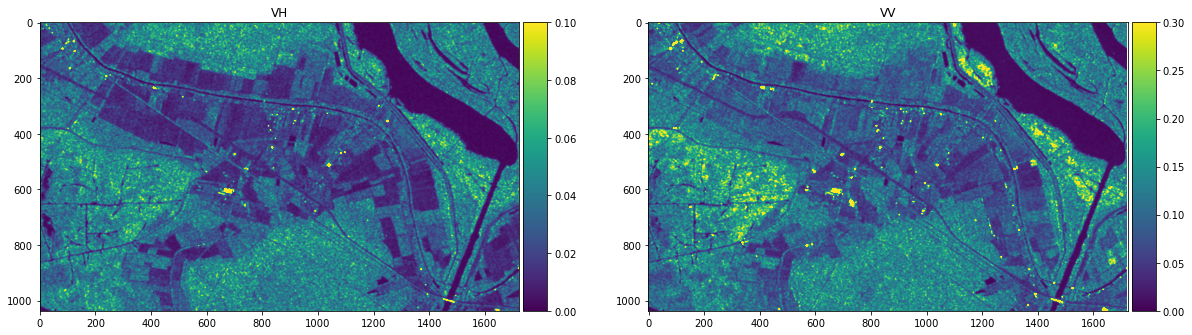

In [24]:
VH = rasterio.open('%s_subset_coreg.tif' %(grds[0][:-4])).read(1)
VV = rasterio.open('%s_subset_coreg.tif' %(grds[0][:-4])).read(2)

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(20,40))
im1 = ax1.imshow(VH,vmin=0,vmax=.1)
im2 = ax2.imshow(VV,vmin=0,vmax=.3)
ax1.set_title('VH')
ax2.set_title('VV')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');